In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
dataku = pd.read_csv('train_test_data.csv')
dataku.shape
dataku.head()

,Unnamed: 0,Fever,Tiredness,Dry-Cough,Difficulty-in-Breathing,Sore-Throat,None_Sympton,Pains,Nasal-Congestion,Runny-Nose,...,Gender_Male,Gender_Transgender,Severity_Mild,Severity_Moderate,Severity_None,Severity_Severe,Contact_Dont-Know,Contact_No,Contact_Yes,Country
0,0,1,1,1,1,1,0,1,1,1,...,1,0,1,0,0,0,0,0,1,China
1,1,1,1,1,1,1,0,1,1,1,...,1,0,1,0,0,0,0,1,0,China
2,2,1,1,1,1,1,0,1,1,1,...,1,0,1,0,0,0,1,0,0,China
3,3,1,1,1,1,1,0,1,1,1,...,1,0,0,1,0,0,0,0,1,China
4,5,1,1,1,1,1,0,1,1,1,...,1,0,0,1,0,0,1,0,0,China


In [3]:
dataku = dataku.drop(["Country","Age_0-9","Age_10-19","Age_20-24","Age_25-59","Age_60+","Gender_Female","Gender_Male","Gender_Transgender","Contact_Dont-Know","Contact_No","Contact_Yes"], axis=1)

In [4]:
val_dataku = dataku.sample(frac=0.2, random_state=1337)
train_dataku = dataku.drop(val_dataku.index)

print(
    "Using %d samples for training and %d for validation"
    % (len(train_dataku), len(val_dataku))
)

Using 202752 samples for training and 50688 for validation


In [5]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = pd.concat([dataframe.pop(x) for x in ['Severity_Mild','Severity_Moderate','Severity_None','Severity_Severe']], axis=1)
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


train_ds = dataframe_to_dataset(train_dataku)
val_ds = dataframe_to_dataset(val_dataku)

In [6]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'Unnamed: 0': <tf.Tensor: shape=(), dtype=int64, numpy=87235>, 'Fever': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'Tiredness': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'Dry-Cough': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'Difficulty-in-Breathing': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'Sore-Throat': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'None_Sympton': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'Pains': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'Nasal-Congestion': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'Runny-Nose': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'Diarrhea': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'None_Experiencing': <tf.Tensor: shape=(), dtype=int64, numpy=0>}
Target: tf.Tensor([0 0 0 1], shape=(4,), dtype=int64)


In [7]:
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

In [8]:
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import StringLookup

In [9]:
def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature

In [10]:
# Categorical features encoded as integers
Fever = keras.Input(shape=(1,), name="Fever", dtype="int64")
Tiredness = keras.Input(shape=(1,), name="Tiredness", dtype="int64")
Dry_Cough = keras.Input(shape=(1,), name="Dry-Cough", dtype="int64")
Difficulty_in_Breathing = keras.Input(shape=(1,), name="Difficulty-in-Breathing", dtype="int64")
Sore_Throat = keras.Input(shape=(1,), name="Sore-Throat", dtype="int64")
None_Sympton = keras.Input(shape=(1,), name="None_Sympton", dtype="int64")
Pains = keras.Input(shape=(1,), name="Pains", dtype="int64")
Nasal_Congestion = keras.Input(shape=(1,), name="Nasal-Congestion", dtype="int64")
Runny_Nose = keras.Input(shape=(1,), name="Runny-Nose", dtype="int64")
Diarrhea = keras.Input(shape=(1,), name="Diarrhea", dtype="int64")
None_Experiencing = keras.Input(shape=(1,), name="None_Experiencing", dtype="int64")

all_inputs = [
    Fever,
    Tiredness,
    Dry_Cough,
    Difficulty_in_Breathing,
    Sore_Throat,
    None_Sympton,
    Pains,
    Nasal_Congestion,
    Runny_Nose,
    Diarrhea,
    None_Experiencing,
]

# Integer categorical features
Fever_encoded = encode_categorical_feature(Fever, "Fever", train_ds, False)
Tiredness_encoded = encode_categorical_feature(Tiredness, "Tiredness", train_ds, False)
Dry_Cough_encoded = encode_categorical_feature(Dry_Cough, "Dry-Cough", train_ds, False)
Difficulty_in_Breathing_encoded = encode_categorical_feature(Difficulty_in_Breathing, "Difficulty-in-Breathing", train_ds, False)
Sore_Throat_encoded = encode_categorical_feature(Sore_Throat, "Sore-Throat", train_ds, False)
None_Sympton_encoded = encode_categorical_feature(None_Sympton, "None_Sympton", train_ds, False)
Pains_encoded = encode_categorical_feature(Pains, "Pains", train_ds, False)
Nasal_Congestion_encoded = encode_categorical_feature(Nasal_Congestion, "Nasal-Congestion", train_ds, False)
Runny_Nose_encoded = encode_categorical_feature(Runny_Nose, "Runny-Nose", train_ds, False)
Diarrhea_encoded = encode_categorical_feature(Diarrhea, "Diarrhea", train_ds, False)
None_Experiencing_encoded = encode_categorical_feature(None_Experiencing, "None_Experiencing", train_ds, False)


all_features = layers.concatenate(
    [
        Fever_encoded,
        Tiredness_encoded,
        Dry_Cough_encoded,
        Difficulty_in_Breathing_encoded,
        Sore_Throat_encoded,
        None_Sympton_encoded,
        Pains_encoded,
        Nasal_Congestion_encoded,
        Runny_Nose_encoded,
        Diarrhea_encoded,
        None_Experiencing_encoded
    ]
)

In [11]:
x = layers.Dense(512, activation="relu")(all_features)
x = layers.Dropout(0.5)(x)
output = layers.Dense(4, activation="softmax")(x)
model = keras.Model(all_inputs, output)
model.compile("adam", "categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Fever (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 Tiredness (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 Dry-Cough (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 Difficulty-in-Breathing (Input  [(None, 1)]         0           []                               
 Layer)                                                                                       

In [12]:
# `rankdir='LR'` is to make the graph horizontal.
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [13]:
history = model.fit(train_ds, epochs=10, batch_size=512, validation_data=val_ds)

Epoch 1/10


D:\ANACONDA\envs\Capstone\lib\site-packages\keras\engine\functional.py:566: UserWarning: Input dict contained keys ['Unnamed: 0'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


6336/6336 [==============================] - 32s 5ms/step - loss: 1.3887 - accuracy: 0.2494 - val_loss: 1.3865 - val_accuracy: 0.2479
Epoch 2/10
6336/6336 [==============================] - 31s 5ms/step - loss: 1.3864 - accuracy: 0.2503 - val_loss: 1.3864 - val_accuracy: 0.2479
Epoch 3/10
6336/6336 [==============================] - 31s 5ms/step - loss: 1.3864 - accuracy: 0.2491 - val_loss: 1.3866 - val_accuracy: 0.2495
Epoch 4/10
6336/6336 [==============================] - 31s 5ms/step - loss: 1.3864 - accuracy: 0.2490 - val_loss: 1.3863 - val_accuracy: 0.2495
Epoch 5/10
6336/6336 [==============================] - 32s 5ms/step - loss: 1.3864 - accuracy: 0.2504 - val_loss: 1.3863 - val_accuracy: 0.2479
Epoch 6/10
6336/6336 [==============================] - 32s 5ms/step - loss: 1.3864 - accuracy: 0.2494 - val_loss: 1.3863 - val_accuracy: 0.2516
Epoch 7/10
6336/6336 [==============================] - 31s 5ms/step - loss: 1.3864 - accuracy: 0.2492 - val_loss: 1.3863 - val_accuracy: 0.2

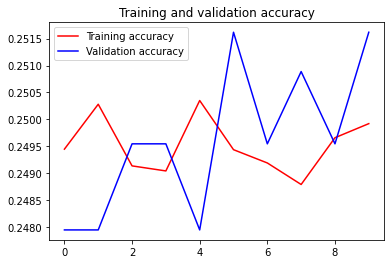

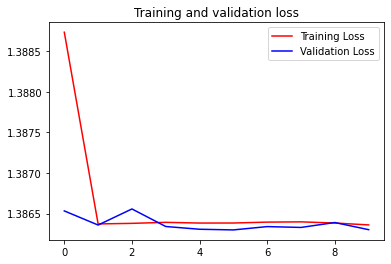

In [14]:
import matplotlib.pyplot as plt
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [15]:
tf.keras.models.save_model(
    model,
    "model_percobaan")

INFO:tensorflow:Assets written to: model_percobaan\assets


INFO:tensorflow:Assets written to: model_percobaan\assets
